## Imports

In [2]:
#imports
import os
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt



# DATA UNDERSTANDING #

[[7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]
 [7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]
 [7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]
 ...
 [7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]
 [7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]
 [7.91624188e-09 7.91624188e-09 7.91624188e-09 ... 7.91624188e-09
  7.91624188e-09 7.91624188e-09]]
(430, 345, 100)
Data type: float64
<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 430 345 100   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_c

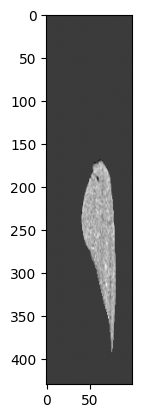

In [16]:
#data imports
dataset_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_segmentations'
dataset_segmentation_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/labels made by AI model cropped'

#first image as an example
image = nib.load(os.path.join(dataset_path, 'CAESAR569_1_0000_padded.nii.gz'))
image_data = image.get_fdata()
print(image_data[:,50,:])
image_header = image.header
print(image_data.shape)
# Check the data type of the image data
print("Data type:", image_data.dtype)

print(image.header)

#show an example image
plt.imshow(image_data[:,50,:], cmap='gray')


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


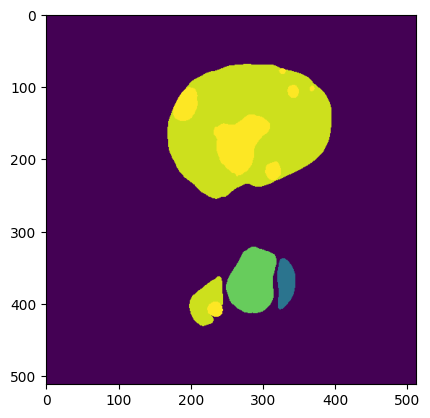

In [23]:
#show segmentation
segm_img = nib.load(os.path.join(dataset_segmentation_path, 'CAESAR001_0.nii.gz'))
segm_img_data = segm_img.get_fdata()
segm_img_header = segm_img.header
print(segm_img_data[:,:,40])

#show an example image
plt.imshow(segm_img_data[:,:,40])


In [26]:
text = "CAESAR001_1_0000.nii.gz"
text[:-12]

'CAESAR001_1'

### all 0_scans

In [ ]:
dataset_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/last scan niftis cropped'
for scan in os.listdir(dataset_path):
    if scan.split("_")[1] == "0":
        print(scan)

### Find segmentations with large number of slices

In [ ]:
dataset_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/boundingbox_liver_segmentations'

i = 0
for scan in os.listdir(dataset_path):
    image = nib.load(os.path.join(dataset_path, scan))
    image_data = image.get_fdata()
    if image_data.shape[2] > 100:
        i += 1


42


In [10]:
#find slice thickness

image = nib.load(os.path.join(dataset_path, 'CAESAR108_0_0000_cropped.nii.gz'))
image_header = image.header
print(image_header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : np.bytes_(b'')
db_name         : np.bytes_(b'')
extents         : 0
session_error   : 0
regular         : np.bytes_(b'r')
dim_info        : 0
dim             : [  3 249 226 366   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int32
bitpix          : 32
slice_start     : 0
pixdim          : [1.       0.818359 0.818359 0.5      1.       1.       1.       1.      ]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 2
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : np.bytes_(b'')
aux_file        : np.bytes_(b'')
qform_code      : scanner
sform_code      : unknown
quatern_b       : 0.0
quatern_c       : 0.0
quatern_d       : 1.0
qoffset_x       : 2

In [13]:
#try to downsize the large image

padded_segm_path = "L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/padded_liver_segmentations"

image = nib.load(os.path.join(dataset_path, 'CAESAR108_0_0000_cropped.nii.gz'))
image_data = image.get_fdata()
image_data = np.copy(image_data)

image_data = np.resize(image_data, (250,250,100))

# Create a new NIfTI image
new_image = nib.Nifti1Image(image_data, affine=image.affine, header=image.header)

# Save the new NIfTI image to a file with the original name
output_file_path = os.path.join(padded_segm_path, 'CAESAR108_0_0000_cropped.nii.gz')
nib.save(new_image, output_file_path)


# Validation dataset

In [ ]:
val_path = None
#convert to nifti

In [10]:
# Load an image from the scan niftis cropped folder
scan_niftis_cropped_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/scan niftis cropped'
test_folder_path = 'L:/Basic/divi/jstoker/slicer_pdac/Master Students WS 24/Martijn/data/test'

# Example scan file
scan_file = 'CAESAR001_1_0000.nii.gz'
image = nib.load(os.path.join(scan_niftis_cropped_path, scan_file))

# Set the fdata to all zeros
image_data = image.get_fdata()
image_data[:] = 0

# Create a new NIfTI image with the modified data
new_image = nib.Nifti1Image(image_data, affine=image.affine, header=image.header)

# Save the new NIfTI image to the test folder
output_file_path = os.path.join(test_folder_path, scan_file)
nib.save(new_image, output_file_path)